# Simulated PDF

In this notebook, I'll run through the steps, coupled with some validation of how to generate a PDF from an event time series.

In [1]:
import sys
sys.path.append("../")

from __init__ import *
from data_tools import *
from testing import *

Below we specify the values for impedance, number of channels, boltzmann constant, bandwidth and number of samples.

We then calculate the noise power, the variance for the time and frequency domain (divided by the number of samples).

In [ ]:
R, Nch, kb, bw, Nsamp, T= 496.1709043911709, 1, 1.38e-23, 500e6, 40960, 5

# R = Impedance
# Nch = No. of channels
# kb = Boltzmann constant
# Nsamp = Number of Samples
# T = Temperature (Kelvin) 

# noise power
n_pwr = kb * T * bw

# noise variance single channel, time-domain (tau_1t)
tau_1t = n_pwr * R

# noise variance single channel, freq-domain (tau_1f)
tau_1f = tau_1t / Nsamp

# single-channel complex wgn with total variance tau_1t
rng = np.random.default_rng()
noise_1t = rng.multivariate_normal([0,0], np.eye(2) * tau_1t/2, Nsamp) # variance is divided by two for correct total variance.
noise_1t = noise_1t[:,0] + 1j * noise_1t[:,1]

print('1 Channel, Time-domain')
print(f'The single-channel time-domain noise variance is --- {tau_1t}')
print(f'The single-channel time-domain sample variance is --- {np.mean(abs(noise_1t)**2)}\n')

noise_1f = np.fft.fft(noise_1t, norm='forward')

print('1 Channel, Freq-domain')
print(f'The single-channel freq-domain noise variance is --- {tau_1f}')
print(f'The single-channel freq-domain sample variance is --- {np.mean(abs(noise_1f)**2)}\n')

1 Channel, Time-domain
The single-channel time-domain noise variance is --- 1.71178962014954e-11
The single-channel time-domain sample variance is --- 1.715101833935171e-11

1 Channel, Freq-domain
The single-channel freq-domain noise variance is --- 4.1791738773182124e-16
The single-channel freq-domain sample variance is --- 4.187260336755789e-16



Here we generate some noise and validate that our generation and CDF calculations align.

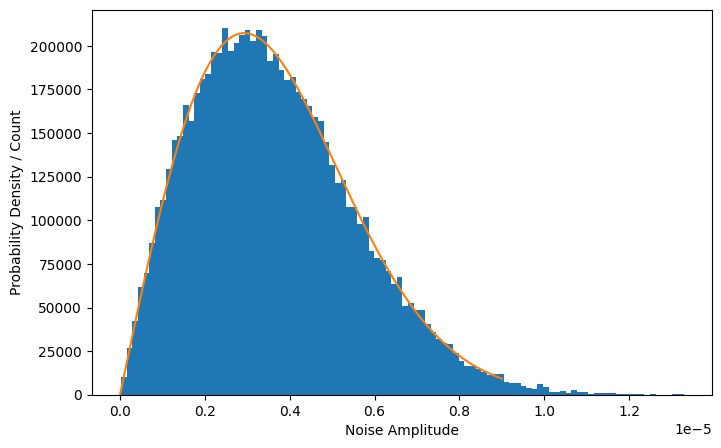

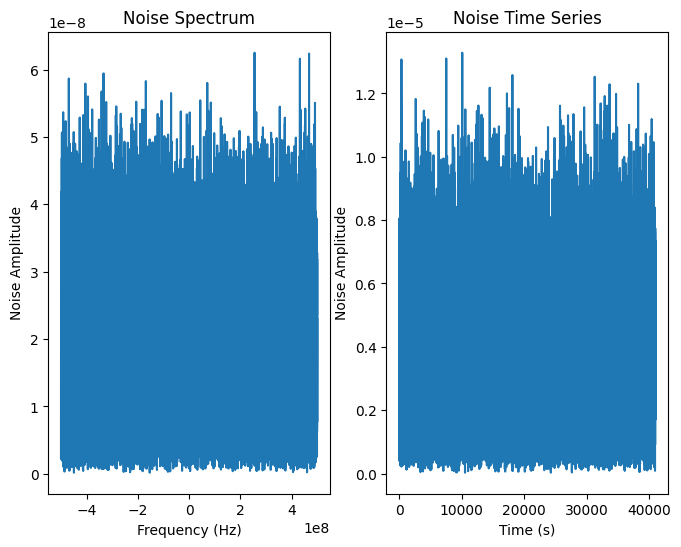

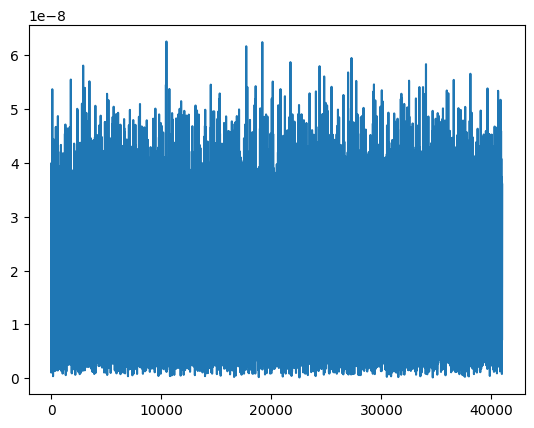

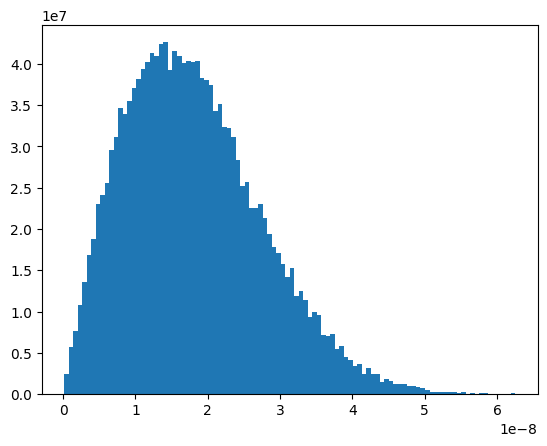

In [149]:
# x = np.linspace(2e-7,5e-7, 1001)
x = np.linspace(1e-9,9e-6, 10001)

ray_cdf = (1-np.exp(-(x**2)/tau_1f)) ** Nsamp
ray_pdf = np.gradient(ray_cdf, x[1]-x[0])
# ray_pdf = ray_pdf/np.trapz(ray_pdf)

# The rayleigh CDF with time domain variance
ray_single_cdf = 1-np.exp(-(x**2)/tau_1t)
# The rayleigh PDF with time domain variance
ray_single_pdf = np.gradient(ray_single_cdf, x[1]-x[0])

noise = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, Nsamp) # Generate a 2d gaussian
noise = noise[:,0] + 1j * noise[:,1] # Sample from said Gaussian to get a complex number 

gaus1 = np.random.normal(0, tau_1t/2, Nsamp)
gaus2 = np.random.normal(0, tau_1t/2, Nsamp)
gaus_full = gaus1 + 1j * gaus2

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
hist = ax.hist(abs(noise), bins=100, density=True)
ax.plot(x,  ray_single_pdf);
# ax.set_xlim(2.5e-7, 4.5e-7)

plt.ylabel('Probability Density / Count')
plt.xlabel('Noise Amplitude')
plt.show()

# ############################################################################################################

noise_FFT = np.fft.fft(noise, norm='forward')
noise_freqs = np.fft.fftfreq(Nsamp, 1e-9)

fig, axs = plt.subplots(1, 2, figsize=(8,6))
axs[0].plot(noise_freqs, abs(noise_FFT))
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Noise Amplitude')
axs[0].set_title('Noise Spectrum')

time = np.linspace(0, Nsamp, Nsamp)
axs[1].plot(time, abs(noise))
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Noise Amplitude')
axs[1].set_title('Noise Time Series')

plt.show()

plt.plot(abs(noise_FFT))

plt.figure()

plt.hist(abs(noise_FFT), bins=100, density=True)
plt.show()


In [156]:
abs_noise = abs(noise_FFT)
abs_noise_squared = abs(noise_FFT)**2

noise_squared = abs(noise)**2 / Nsamp

print('FFT: ', np.sum(abs_noise_squared))
print('Time: ', np.sum(noise_squared))

FFT:  1.7060059933419188e-11
Time:  1.7060059933419188e-11


0.02562730803737955


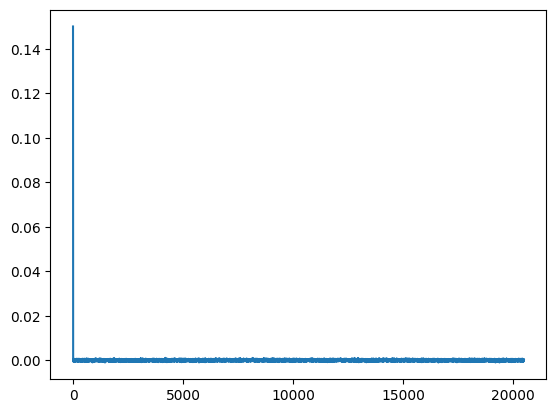

In [113]:
# Weird occurence

real_noise_FFT = np.fft.rfft(abs(noise))

plt.plot(real_noise_FFT)

print(np.sum(abs(real_noise_FFT)**2));

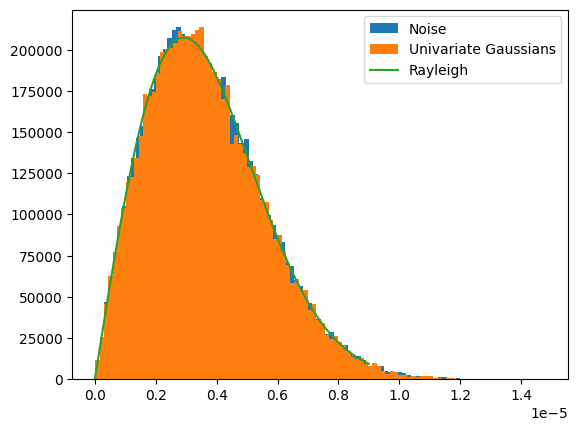

In [119]:
noise = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, Nsamp) # Generate a 2d gaussian
noise = noise[:,0] + 1j * noise[:,1] # Sample from said Gaussian to get a complex number 

gaus1 = np.random.normal(0, np.sqrt(tau_1t/2), Nsamp)
gaus2 = np.random.normal(0, np.sqrt(tau_1t/2), Nsamp)
gaus_full = gaus1 + 1j * gaus2

ray_single_cdf = 1-np.exp(-(x**2)/tau_1t)
ray_single_pdf = np.gradient(ray_single_cdf, x[1]-x[0])

plt.hist(abs(noise), bins=100, density=True, label='Noise')
plt.hist(abs(gaus_full), bins=100, density=True, label='Univariate Gaussians')
plt.plot(x, ray_single_pdf, label='Rayleigh')
plt.legend()
plt.show()

In [ ]:
N = 100
scale_factor = 1

# peaks = np.array(
#     [5e-7-1j*5e-7,
#      3e-7+1j*3e-7,
#      3e-7-1j*3e-7,
#      2e-7+1j*2e-7]) * scale_factor
# peak_inds = np.array([2000, 2500, 3000, 3500])

# peaks = np.array(
#     [5e-7-1j*5e-7,
#      ]) * scale_factor

# peak_inds = np.array([2500])   

# peaks = np.array(
# [3e-6 + 1j*3e-6])

# peaks = np.array ([-2.2603420079264848e-05 + 1j*1.0352802618506447e-05])

peaks = np.array([2e-7 + 1j*2e-7])

peak_inds = np.array([50])

print(np.abs(peaks))

lots_of_noise = rng.multivariate_normal([0,0],np.eye(2)*tau_1f/2, N*Nsamp)
lots_of_noise = lots_of_noise[:,0] + 1j * lots_of_noise[:,1]
lots_of_noise = lots_of_noise.reshape(Nsamp, N)
noise_maxima = np.max(abs(lots_of_noise),axis=1)

lots_of_noise[:, peak_inds] += peaks
signal_maxima = np.max(abs(lots_of_noise),axis=1) 

# plt.figure()
# plt.hist(signal_maxima, bins=100, density=True, histtype='step', label='Hist')
# plt.tight_layout()
# plt.show()


# y = np.linspace(1e-7, 9e-7, 2001)

from scipy import special

y = np.linspace(1e-6, 1e-4, 20001)

rice_cdf = np.ones(20001)
for peak in peaks:
    rice_cdf *= scipy.stats.rice.cdf(y, abs(peak)/np.sqrt(tau_1f/2), scale=np.sqrt(tau_1f/2))
    
signal_cdf = rice_cdf * ( (1-np.exp(-(y**2)/tau_1f)) ** (Nsamp-peaks.size) )

signal_pdf = np.gradient(signal_cdf, y[1]-y[0])

print(Nsamp)


[2.82842712e-07]
40960
40960


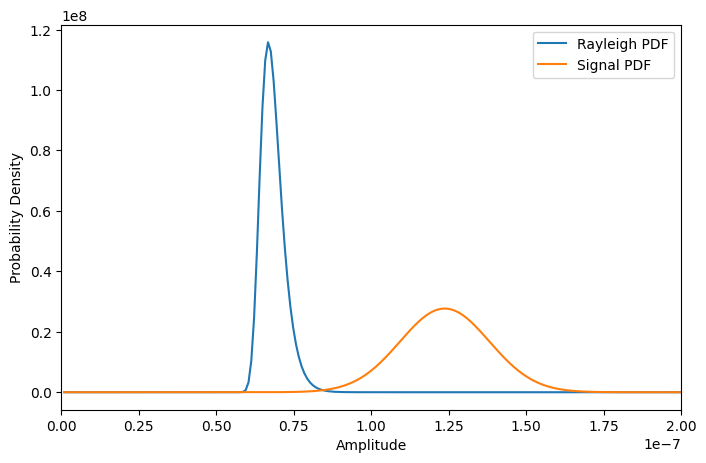

In [ ]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

y = np.linspace(1e-9, 1e-5, 20001)

noise_f = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, Nsamp) # Generate a 2d gaussian
noise_f = noise_f[:,0] + 1j * noise_f[:,1]


# H0
ray_cdf = (1-np.exp(-(x**2)/tau_1f)) ** Nsamp
ray_pdf = np.gradient(ray_cdf, x[1]-x[0])

peaks = np.array([
                  
                  -1.116848286875947e-07+ 1j * 5.115380693849318e-08])


# peak_inds = np.array([50])

# noise_f[:, peak_inds] += peaks
# signal_maxima = np.max(abs(lots_of_noise),axis=1) 

rice_cdf = np.ones(20001)
for peak in peaks:
    rice_cdf *= scipy.stats.rice.cdf(y, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
    
signal_cdf = rice_cdf * (1-np.exp(-(y**2)/tau_1f)) ** (Nsamp-peaks.size)

signal_pdf = np.gradient(signal_cdf, y[1]-y[0])

# hist = ax.hist(noise_f, bins=100, density=True, histtype='step', label='Noise Hist' )
# hist = ax.hist(signal_maxima, bins=100, density=True, histtype='step', label='Hist')

ax.plot(x, ray_pdf, label='Rayleigh PDF')
ax.plot(y, signal_pdf, label = 'Signal PDF')

ax.set_xlabel('Amplitude')
ax.set_ylabel('Probability Density')

ax.set_xlim(0.0, 2e-7)

ax.legend();

In [147]:
print(np.sqrt(tau_1f/2))

print(peaks)

1.4455403621688003e-08
[2.e-07+2.e-07j]


(0.0, 5e-07)

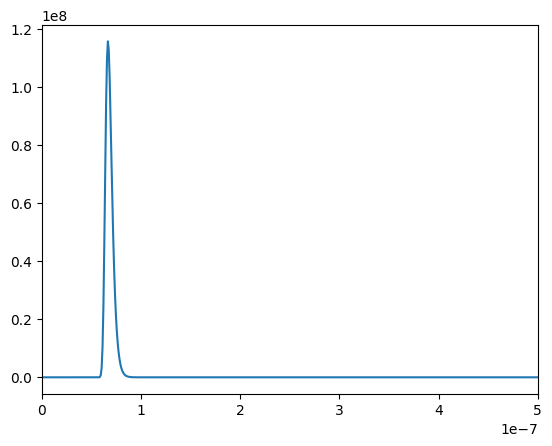

In [52]:
plt.plot(x, ray_pdf, label='Rayleigh PDF')
plt.xlim(0, 5e-7)

In [171]:
file_ = 'harmonic/86p5deg/out_0aa72c89-416e-4f11-8eda-ae7542078817.h5'

# file_ = 'harmonic/90deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5'

signal_strings, attributes, attrs_container = get_attributes(file_)
signal = get_signal(file_, 'signal1') # One polarisation
signal_FFT = np.fft.fft(signal, norm='forward')

signal_max = np.max(abs(signal_FFT))
signal_max_index = np.argmax(abs(signal_FFT))
complex_signal_max = signal_FFT[signal_max_index]

print(complex_signal_max)
print(signal_max)

(9.609851997553602e-09+3.639786768913486e-08j)
3.764510629192927e-08


/Users/nathan/miniforge3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nathan/miniforge3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


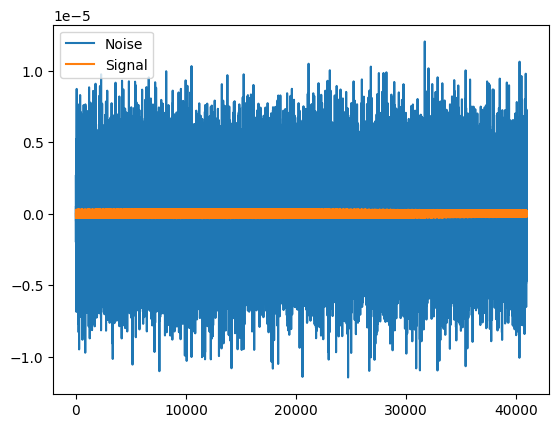

In [172]:
noise = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, Nsamp) # Generate a 2d gaussian
noise = noise[:,0] + 1j * noise[:,1]
# noise
# signal

noise_FFT = np.fft.fft(noise, norm='forward')

plt.plot(noise, label='Noise')
plt.plot(signal, label='Signal')

plt.legend()
plt.show();

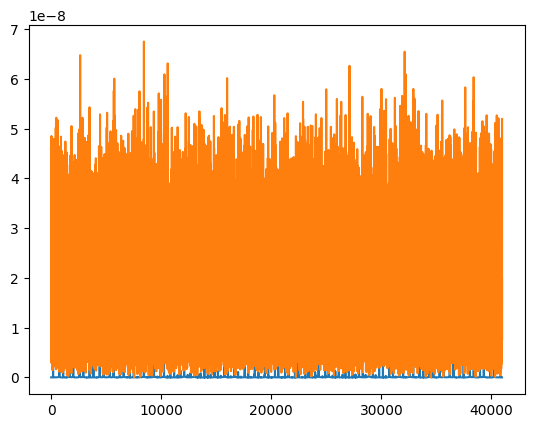

In [173]:
plt.plot(abs(signal_FFT))
plt.plot(abs(noise_FFT))

In [126]:
fft_summed = np.sum(abs(signal_FFT)**2)
time_summed = np.sum(abs(signal)**2)

print('Signal Total Power:')
print('FFT:  ',  fft_summed)
print('Time: ', time_summed)

print(fft_summed/time_summed)

print('Ratio of Freq/Time Domain Power', fft_summed/time_summed)

print('####################')

# Same as above but for noise

fft_summed = np.sum(abs(noise_FFT)**2)
time_summed = np.sum(abs(noise)**2)

print('Noise Total Power:')
print('FFT:  ', fft_summed)
print('Time: ', time_summed)

print('Ratio of Freq/Time Domain Power', fft_summed/time_summed)

Signal Total Power:
FFT:   1.976992947039764e-09
Time:  1.976992947039764e-09
1.0
Ratio of Freq/Time Domain Power 1.0
####################
Noise Total Power:
FFT:   7.010565920446494e-07
Time:  7.024842796206756e-07
Ratio of Freq/Time Domain Power 0.9979676590388654


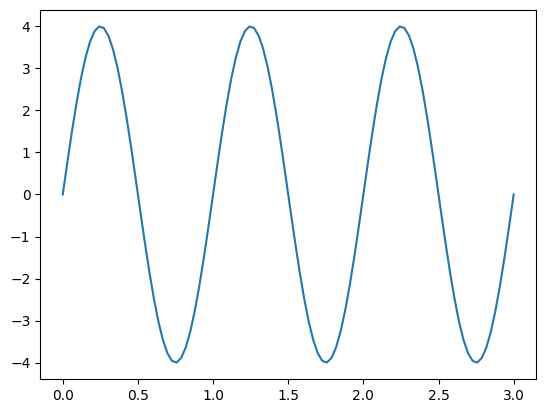

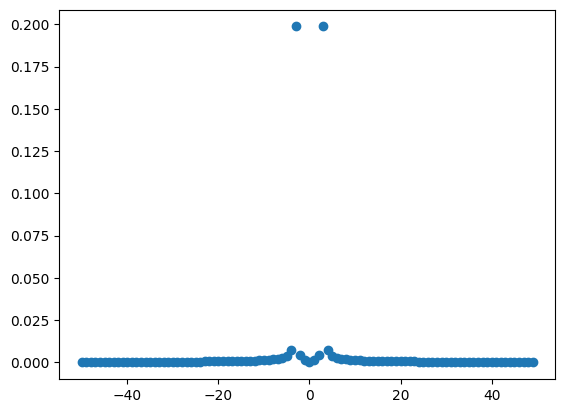

792.0000000000003
791.9999999999999
1.0000000000000004


In [63]:
vals = np.linspace(0, 3, 100)

output = 4 * np.sin(2*np.pi*vals)

plt.plot(vals, output)

sin_fft = np.fft.fft(output, norm='ortho')

plt.figure()
plt.scatter(np.fft.fftfreq(len(sin_fft), 1/100), abs(sin_fft)/len(sin_fft))
plt.show();

print(np.sum(abs(sin_fft)**2))
print(np.sum(abs(output)**2))

print(np.sum(abs(sin_fft)**2 / np.sum(abs(output)**2)))

# Generating Plots

''

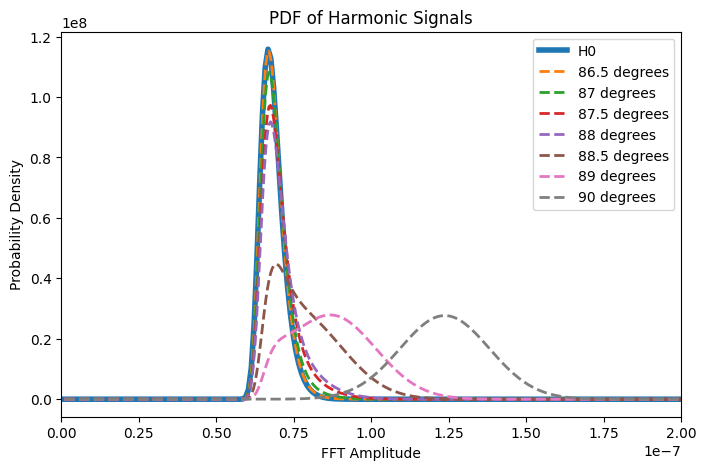

In [206]:
file_list = ['harmonic/86p5deg/out_0aa72c89-416e-4f11-8eda-ae7542078817.h5', 
    'harmonic/87deg/out_0a5c4e19-2fc3-4f5c-9090-8d2cce62ae19.h5', 
    'harmonic/87p5deg/out_0c7fdf39-0ea3-4c84-9a9d-60c68b480bb1.h5', 
    'harmonic/88deg/out_0ad74f8f-ec02-44f5-a5af-5c69bef4774e.h5',
    'harmonic/88p5deg/out_0a1bc7f8-6e25-47f3-9743-f404227c3d0b.h5',
    'harmonic/89deg/out_1a0ad631-1153-47ef-8cba-ea9ab0cefa3d.h5',
    'harmonic/90deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5']

harmonic_angles = ['86.5', '87', '87.5', '88', '88.5', '89', '90']



fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

plt.title('PDF of Harmonic Signals')

y = np.linspace(1e-9, 1e-5, 20001)

noise_f = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, Nsamp) # Generate a 2d gaussian
noise_f = noise_f[:,0] + 1j * noise_f[:,1]


# H0
ray_cdf = (1-np.exp(-(x**2)/tau_1f)) ** Nsamp
ray_pdf = np.gradient(ray_cdf, x[1]-x[0])

ax.plot(x, ray_pdf, label='H0', lw=4)

for i, file_ in enumerate(file_list):


    signal_strings, attributes, attrs_container = get_attributes(file_)
    signal = get_signal(file_, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    signal_max = np.max(abs(signal_FFT))
    signal_max_index = np.argmax(abs(signal_FFT))
    complex_signal_max = signal_FFT[signal_max_index]


    peaks = np.array([complex_signal_max])


    # peak_inds = np.array([50])

    # noise_f[:, peak_inds] += peaks
    # signal_maxima = np.max(abs(lots_of_noise),axis=1) 

    rice_cdf = np.ones(20001)
    for peak in peaks:
        rice_cdf *= scipy.stats.rice.cdf(y, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
        
    signal_cdf = rice_cdf * (1-np.exp(-(y**2)/tau_1f)) ** (Nsamp-peaks.size)

    signal_pdf = np.gradient(signal_cdf, y[1]-y[0])

    # hist = ax.hist(noise_f, bins=100, density=True, histtype='step', label='Noise Hist' )
    # hist = ax.hist(signal_maxima, bins=100, density=True, histtype='step', label='Hist')

    # linestyles = ['--', '-.', '-', ':', '-.', '--', '-']

    signal_label = str(harmonic_angles[i]) + ' degrees'
    ax.plot(y, signal_pdf, label = signal_label, ls='--', lw=2)

ax.set_xlabel('FFT Amplitude')
ax.set_ylabel('Probability Density')

ax.set_xlim(0.0, 2e-7)

ax.legend()

plt.savefig('../figures/harmonic_signals_PDF.pdf', format='pdf', dpi=300)
plt.savefig('../figures/harmonic_signals_PDF.png', format='png', dpi=300)
;

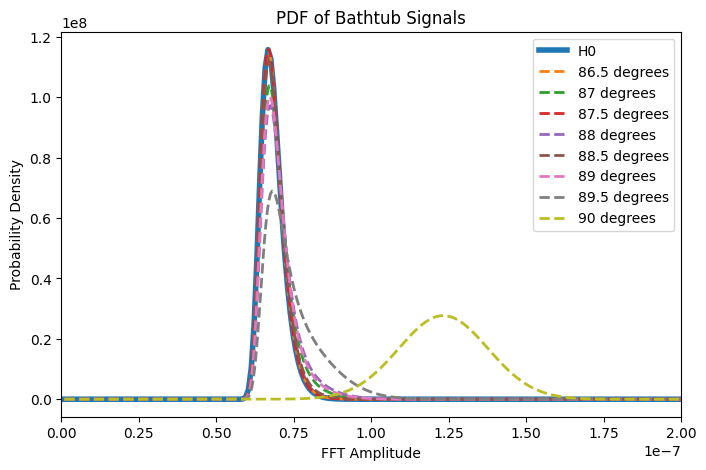

In [207]:
data_paths = '../data/bathtub/**/*.h5'
file_list_bath = [
 'bathtub/86p5deg/out_0d096f21-981a-468e-aaac-00bcc351c1fe.h5',
 'bathtub/87deg/out_0a12956a-3496-409c-88a8-6f4772eb1f88.h5',
 'bathtub/87p5deg/out_0ebb2189-221e-4e65-8b26-cd7f0b39368e.h5',
 'bathtub/88deg/out_0a3e80ad-1d5a-4d21-9704-6e50e240fdea.h5',
 'bathtub/88p5deg/out_0a2fa0ce-10be-4457-b781-1d4d961582d0.h5',
 'bathtub/89deg/out_0d737c3e-146a-4958-9dff-3d101f342b46.h5',
 'bathtub/89p5deg/out_0f47865a-b68b-4e22-a86e-ba100b152012.h5',
 'bathtub/90deg/out_0af13536-3a60-4a74-b42c-3c85aabfa86c.h5'
 ]

bath_angles = ['86.5', '87', '87.5', '88', '88.5', '89', '89.5', '90']


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

plt.title('PDF of Bathtub Signals')

y = np.linspace(1e-9, 1e-5, 20001)

noise_f = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, Nsamp) # Generate a 2d gaussian
noise_f = noise_f[:,0] + 1j * noise_f[:,1]


# H0
ray_cdf = (1-np.exp(-(x**2)/tau_1f)) ** Nsamp
ray_pdf = np.gradient(ray_cdf, x[1]-x[0])

ax.plot(x, ray_pdf, label='H0', lw=4)

for i, file_ in enumerate(file_list_bath):

    signal_strings, attributes, attrs_container = get_attributes(file_)
    signal = get_signal(file_, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    signal_max = np.max(abs(signal_FFT))
    signal_max_index = np.argmax(abs(signal_FFT))
    complex_signal_max = signal_FFT[signal_max_index]


    peaks = np.array([complex_signal_max])


    # peak_inds = np.array([50])

    # noise_f[:, peak_inds] += peaks
    # signal_maxima = np.max(abs(lots_of_noise),axis=1) 

    rice_cdf = np.ones(20001)
    for peak in peaks:
        rice_cdf *= scipy.stats.rice.cdf(y, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
        
    signal_cdf = rice_cdf * (1-np.exp(-(y**2)/tau_1f)) ** (Nsamp-peaks.size)

    signal_pdf = np.gradient(signal_cdf, y[1]-y[0])

    # hist = ax.hist(noise_f, bins=100, density=True, histtype='step', label='Noise Hist' )
    # hist = ax.hist(signal_maxima, bins=100, density=True, histtype='step', label='Hist')

    signal_label = str(bath_angles[i]) + ' degrees'
    ax.plot(y, signal_pdf, label = signal_label, ls='--', lw=2)

ax.set_xlabel('FFT Amplitude')
ax.set_ylabel('Probability Density')

ax.set_xlim(0.0, 2e-7)

plt.savefig('../figures/bathtubs_signals_PDF.pdf', format='pdf', dpi=300)
plt.savefig('../figures/bathtubs_signals_PDF.png', format='png', dpi=300)

ax.legend();

In [205]:
figures = '../figures/'

glob.glob(figures + '/*.pdf')

['../figures/bathtubs_signals.pdf']